## Imports

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC

In [135]:
# Reading in datasets created in the 1_Scraping_and_cleaning notebook
titles_and_text = pd.read_csv('./Data/titles_and_text.csv')
titles_and_text_no_cw_or_sudoku = pd.read_csv('./Data/titles_and_text_no_cw_or_sud.csv')

## Exploratory Data Analysis and Modeling Preparation

/Users/gcano01/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gcano01/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


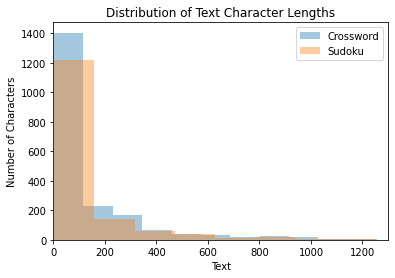

In [136]:
# Plotting the distribution of length for each text by crossword and sudoku subreddit

cw_length = titles_and_text[titles_and_text['subreddit'] == 1]['text'].str.len()
sns.distplot(cw_length, label='Crossword', kde=False)
sud_length = titles_and_text[titles_and_text['subreddit'] == 0]['text'].str.len()
sns.distplot(sud_length, label='Sudoku', kde=False)
plt.title('Distribution of Text Character Lengths')
plt.xlabel('Text')
plt.ylabel('Number of Characters')
plt.xlim(0, 1300)
plt.legend();

Some of the above plotting is based off code from this Kaggle [page](https://www.kaggle.com/pceccon/countvectorizer-and-tfidf-strategies). 

In [137]:
print(f'Mean length of crossword text: {cw_length.mean()}.')
print(f'Mean length of sudoku text: {sud_length.mean()}.') 

Mean length of crossword text: 153.50397614314116.
Mean length of sudoku text: 139.4848284960422.


Takeaway: on average, post titles and selftexts are slightly longer in the crossword subreddit than in the sudoku subreddit.

In [138]:
titles_and_text.groupby(['subreddit'])['text'].describe()

,count,unique,top,freq
subreddit,,,,
0,1516,1438,help,11
1,2012,1718,a weekly open discussion about crosswords and ...,48


Takeaway: the most frequent crossword post is the selftext for a discussion thread that's posted on the subreddit every week.

In [139]:
# Creating two sets of predicter and target variables -- one with 'crossword' and 'sudoku' 
# included, another without them included.

X = titles_and_text['lemmatized_text']
y = titles_and_text['subreddit'] 

X_omit = titles_and_text_no_cw_or_sudoku['lemmatized_text'] 
y_omit = titles_and_text_no_cw_or_sudoku['subreddit']

In [140]:
# Baseline accuracy for modeling is ~57%
y.value_counts(normalize=True)

1    0.570295
0    0.429705
Name: subreddit, dtype: float64

In [141]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=42)
X_train_omit, X_test_omit, y_train_omit, y_test_omit = train_test_split(X_omit, 
                                                                        y_omit, 
                                                                        test_size = 0.3, 
                                                                        stratify = y, random_state=42)

In [142]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
stopwords = list(stopwords)

In [143]:
# bad_words contains words to remove from the CountVectorize transformation, adding to the imported stopwords list 
bad_words = ['https', 'http', 'com', 'www', 'redd', 'reddit', 'gt', 'lt', 've']
stopwords.extend(bad_words)

In [144]:
# Instantiating CountVectorizer
cvec = CountVectorizer(stop_words=stopwords, min_df=3)

In [145]:
# Fitting CountVectorizer with X_train_omit data
fitted = cvec.fit(X_train_omit.values.astype('U'))
X_train_cvec = fitted.transform(X_train_omit.values.astype('U'))

In [146]:
# Transforming X_test data using the CountVectorizer fitted with X_test_omit
X_test_cvec = fitted.transform(X_test_omit.values.astype('U'))

Found .values.astype('U') code from this [stackoverrun](https://stackoverrun.com/de/q/10828749).

In [147]:
print(X_train_cvec.shape)
print(X_test_cvec.shape)

(2469, 1444)
(1059, 1444)


In [148]:
# Making X_train_cvec into a DataFrame
X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())

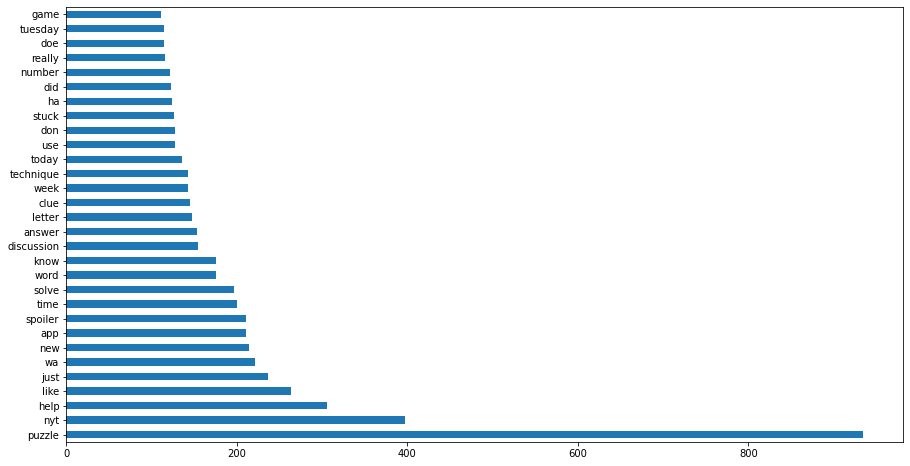

In [149]:
# Plotting most common words from DataFrame
plt.figure(figsize=(15,8))
X_train_cvec_df.sum().sort_values(ascending=False).head(30).plot(kind='barh');

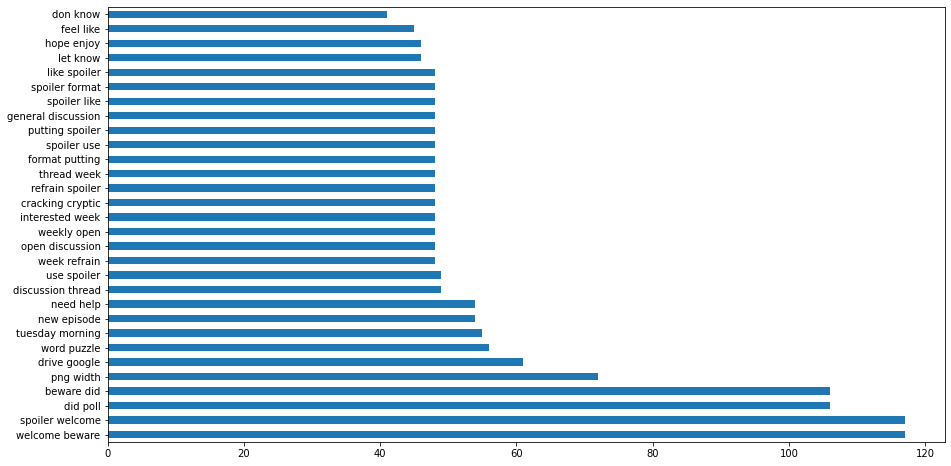

In [150]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords)
cv_bigrams.fit(X_train_omit)

bigrams_cv = cv_bigrams.transform(X)
bigrams_df = pd.DataFrame(bigrams_cv.todense(),
                          columns=cv_bigrams.get_feature_names())

plt.figure(figsize=(15,8))

bigrams_df.sum().sort_values(ascending=False).head(30).plot(kind = 'barh');

Above code partially drawn from Lab 5.01. 

There are plenty of posts welcoming users to threads while also warning against spoilers, since the answers to puzzles often get discussed. 

## Modeling

The structure of the below modeling code is partially taken from Lab Review 5.02 and from Lesson 6.03.

In [151]:
# Pipeline Grid Search on a Logistic Regression Model
# Adding the best parameters and scores to model_params dictionary

model_params = {}
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('logreg', LogisticRegression(solver = 'liblinear'))
])

pipe_params_lr = {
    'cvec__max_features': [1000, 2000, None],
    'cvec__stop_words'  : [None, 'english', stopwords],
    'tf__use_idf': [True, False], #if True, acts like TFIDF, if False, acts like CountVectorizer
    'logreg__penalty' : ['l2', 'l1'],
    'logreg__C' : [0.1, 1, 10]
}

gs_lr = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, cv=5, n_jobs=6)
gs_lr.fit(X_train, y_train)

gs_lr.best_params_['gs_best_score'] = gs_lr.best_score_
gs_lr.best_params_['train_score'] = gs_lr.score(X_train, y_train)
gs_lr.best_params_['test_score'] = gs_lr.score(X_test, y_test)
model_params['logreg_model'] = gs_lr.best_params_

In [152]:
# Performing the above Pipeline Grid Search on the training data that ommitted the words
# 'crossword' and 'sudoku'.
# Adding the best parameters and scores to model_params_omit dictionary

model_params_omit = {}

gs_lr_omit = GridSearchCV(pipe_lr, param_grid=pipe_params_lr, cv=5, n_jobs=6)
gs_lr_omit.fit(X_train_omit, y_train_omit)

gs_lr_omit.best_params_['gs_best_score'] = gs_lr_omit.best_score_
gs_lr_omit.best_params_['train_score'] = gs_lr_omit.score(X_train_omit, y_train_omit)
gs_lr_omit.best_params_['test_score'] = gs_lr_omit.score(X_test_omit, y_test_omit)
model_params_omit['logreg_model'] = gs_lr_omit.best_params_

In [153]:
# Pipeline Grid Search on a Support Vector Classifier Model
# Adding the best parameters and scores to model_params dictionary

pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('svc', SVC(degree=2))
])

pipe_params_svc = {
    'cvec__max_features': [1000, 2000, None],
    'cvec__stop_words'  : [None, 'english', stopwords],
    'tf__use_idf': [True, False], #if True, acts like TFIDF, if False, acts like CountVectorizer
    'svc__C' : [.1, 1, 10],
    'svc__gamma' : ['scale', 'auto']
}

gs_svc = GridSearchCV(pipe_svc, param_grid=pipe_params_svc, cv=5, n_jobs=6)
gs_svc.fit(X_train, y_train)

gs_svc.best_params_['gs_best_score'] = gs_svc.best_score_
gs_svc.best_params_['train_score'] = gs_svc.score(X_train, y_train)
gs_svc.best_params_['test_score'] = gs_svc.score(X_test, y_test)
model_params['svc_model'] = gs_svc.best_params_

In [154]:
# Performing the above Pipeline Grid Search on the training data that ommitted the words
# 'crossword' and 'sudoku'.
# Adding the best parameters and scores to model_params_omit dictionary

gs_svc_omit = GridSearchCV(pipe_svc, param_grid=pipe_params_svc, cv=5, n_jobs=6)
gs_svc_omit.fit(X_train_omit, y_train_omit)

gs_svc_omit.best_params_['gs_best_score'] = gs_svc_omit.best_score_
gs_svc_omit.best_params_['train_score'] = gs_svc_omit.score(X_train_omit, y_train_omit)
gs_svc_omit.best_params_['test_score'] = gs_svc_omit.score(X_test_omit, y_test_omit)
model_params_omit['svc_model'] = gs_svc_omit.best_params_

In [155]:
# Pipeline Grid Search on a Naive Bayes Model
# Adding the best parameters and scores to model_params dictionary

pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

pipe_params_nb = {
    'cvec__max_features': [1000, 2000, None],
    'cvec__stop_words'  : [None, 'english', stopwords],
    'tf__use_idf': [True, False], #if True, acts like TFIDF, if False, acts like CountVectorizer
    'nb__alpha' : [.1, 1, 10],
    'nb__fit_prior' : [True, False]
}

gs_nb = GridSearchCV(pipe_nb, param_grid=pipe_params_nb, cv=5, n_jobs=6)
gs_nb.fit(X_train, y_train)

gs_nb.best_params_['gs_best_score'] = gs_nb.best_score_
gs_nb.best_params_['train_score'] = gs_nb.score(X_train, y_train)
gs_nb.best_params_['test_score'] = gs_nb.score(X_test, y_test)
model_params['nb_model'] = gs_nb.best_params_

In [156]:
# Performing the above Pipeline Grid Search on the training data that omitted the words
# 'crossword' and 'sudoku'.
# Adding the best parameters and scores to model_params_omit dictionary

gs_nb_omit = GridSearchCV(pipe_nb, param_grid=pipe_params_nb, cv=5, n_jobs=6)
gs_nb_omit.fit(X_train_omit, y_train_omit)

gs_nb_omit.best_params_['gs_best_score'] = gs_nb_omit.best_score_
gs_nb_omit.best_params_['train_score'] = gs_nb_omit.score(X_train_omit, y_train_omit)
gs_nb_omit.best_params_['test_score'] = gs_nb_omit.score(X_test_omit, y_test_omit)
model_params_omit['nb_model'] = gs_nb_omit.best_params_

In [157]:
# Making model_params into a DataFrame, which shows the best parameters and test/train scores for each model,
# sorted by highest average Grid Search score.

models_df = pd.DataFrame.from_dict(model_params, orient='index')
models_df.sort_values(by= 'gs_best_score', ascending=False)

,cvec__max_features,cvec__stop_words,logreg__C,logreg__penalty,tf__use_idf,gs_best_score,train_score,test_score,svc__C,svc__gamma,nb__alpha,nb__fit_prior
svc_model,None,None,NaN,NaN,True,0.940866,0.997975,0.930123,10.0,scale,NaN,NaN
logreg_model,None,None,10.0,l2,True,0.936004,0.995950,0.928234,NaN,NaN,NaN,NaN
nb_model,None,None,NaN,NaN,False,0.933985,0.978129,0.930123,NaN,NaN,0.1,True


In [158]:
# Making model_params_omit into a DataFrame, which shows the best parameters and test/train scores for each model,
# sorted by highest average Grid Search score.

models_df_omit = pd.DataFrame.from_dict(model_params_omit, orient='index')
models_df_omit.sort_values(by= 'gs_best_score', ascending=False)

,cvec__max_features,cvec__stop_words,logreg__C,logreg__penalty,tf__use_idf,gs_best_score,train_score,test_score,svc__C,svc__gamma,nb__alpha,nb__fit_prior
svc_model,NaN,None,NaN,NaN,True,0.900365,0.997975,0.898961,10.0,scale,NaN,NaN
logreg_model,NaN,None,10.0,l2,True,0.897121,0.991090,0.893296,NaN,NaN,NaN,NaN
nb_model,2000.0,None,NaN,NaN,True,0.894697,0.953017,0.897073,NaN,NaN,0.1,True


In [159]:
test_coef = models_df_omit.sort_values(by= 'gs_best_score', ascending=False)[['test_score']]
test_coef.rename(columns={'test_score':'Test Score (Crossword and Sudoku Omitted)'}, inplace = True)
test_coef['test_score'] = models_df.sort_values(by= 'gs_best_score', ascending=False)['test_score']
test_coef.rename(columns={'test_score':'Test Score'}, inplace=True)

In [160]:
train_coef = models_df_omit.sort_values(by= 'gs_best_score', ascending=False)[['train_score']]
train_coef.rename(columns={'train_score':'Train Score (Crossword and Sudoku Omitted)'}, inplace = True)
train_coef['train_score'] = models_df.sort_values(by= 'gs_best_score', ascending=False)['train_score']
train_coef.rename(columns={'train_score':'Train Score'}, inplace=True)

In [161]:
coefs = pd.concat([train_coef, test_coef], axis=1)

In [162]:
coefs[['Train Score', 'Train Score (Crossword and Sudoku Omitted)', 'Test Score', 'Test Score (Crossword and Sudoku Omitted)']]

,Train Score,Train Score (Crossword and Sudoku Omitted),Test Score,Test Score (Crossword and Sudoku Omitted)
svc_model,0.997975,0.997975,0.930123,0.898961
logreg_model,0.995950,0.991090,0.928234,0.893296
nb_model,0.978129,0.953017,0.930123,0.897073


## Interpretation of scores

After omitting 'crossword' and 'sudoku' from the Reddit text, the gs_best_scores shrank ~4%, train_scores stayed relatively the same, and test_scores shrank 3-4% for each of the three models. 

- Logistic Regression, Naive Bayes, and Support Vector Classifier all received similarly high scores when predicting with both sets of data (kept and omitted). 
- **Logistic Regression** produced the highest test score when the data included 'crossword' and 'sudoku' in the text, while the **Support Vector Classifier** produced the highest test score when the data omitted those two words. 
- Higher test scores typically indicate that a model is less overfit, which suggests that Logistic Regression and Support Vector Classifier are the ideal models to leverage with their respective aforementioned datasets. 

Since the presence of 'crossword' and 'sudoku' in the text column are obvious indicators of the corresponding subreddit values (they're the titles of the actual subreddits), it's likely more insightful to explore feature importance and other modes of interpretation with the data that omit those words. 

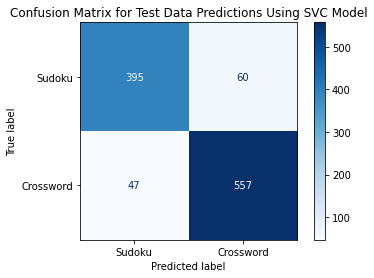

In [163]:
# Creating a confusion matrix from the Support Vector Classifier model
preds_svc_omit = gs_svc_omit.predict(X_test_omit)

tn, fp, fn, tp = confusion_matrix(y_test_omit, preds_svc_omit).ravel()

plot_confusion_matrix(gs_svc_omit, X_test_omit, y_test_omit, cmap='Blues', values_format='d')
plt.xticks(ticks=[0,1], labels=['Sudoku', 'Crossword'])
plt.yticks(ticks=[0,1], labels=['Sudoku', 'Crossword'])
plt.title('Confusion Matrix for Test Data Predictions Using SVC Model');

In [164]:
# Calculating classification metrics from the confusion matrix
spec = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sens = tp / (tp + fn)
misclass = 1 - accuracy

print('Accuracy:', accuracy) # What percentage of observations did I correctly predict?
print('Misclassification Rate:', misclass) # What percentage of observations did I incorrectly predict?
print('Sensitivity:', sens) # Among all the text from crossword subreddit, how many did I get correct?
print('Specificity:', spec) # Among all the text from sudoku subreddit, how many did I get correct?

Accuracy: 0.898961284230406
Misclassification Rate: 0.101038715769594
Sensitivity: 0.9221854304635762
Specificity: 0.8681318681318682


- The SVC model predicted 89.9% of observations correctly. 
- Among all the text from crossword subreddit, 92.2% were correctly predicted to be in the crossword subreddit. 
- Among all the text from sudoku subreddit, 86.8% were correctly predicted to be in the sudoku subreddit. 

In [165]:
# Fitting a Logistic Regression model with CountVectorized data
model = LogisticRegression()
model.fit(X_train_cvec, y_train_omit)

LogisticRegression()

In [166]:
# Sorting the index of the coefficient list and grabbing feature names
sorted_coef_index = model.coef_[0].argsort()
feature_names = np.array(fitted.get_feature_names())

In [167]:
# Grabbing the top ten highest coefficients and top ten lowest coefficients

data = {'Smallest Coefficients' : feature_names[sorted_coef_index[:10]],
        'Largest Coefficients' : feature_names[sorted_coef_index[:-11:-1]]}
significant_coefs = pd.DataFrame(data)

significant_coefs

,Smallest Coefficients,Largest Coefficients
0,hard,nyt
1,technique,word
2,stuck,themeless
3,logic,themed
4,killer,answer
5,variant,clue
6,strategy,tuesday
7,expert,puz
8,cracking,saturday
9,step,theme


In [168]:
# Grabbing the values of the ordered list of coefficients
ordered_coef_vals = model.coef_[0][model.coef_[0].argsort()]
ordered_coef_vals

array([-2.62262302, -2.50337654, -2.14022108, ...,  2.22747381,
        2.35223738,  2.73915714])

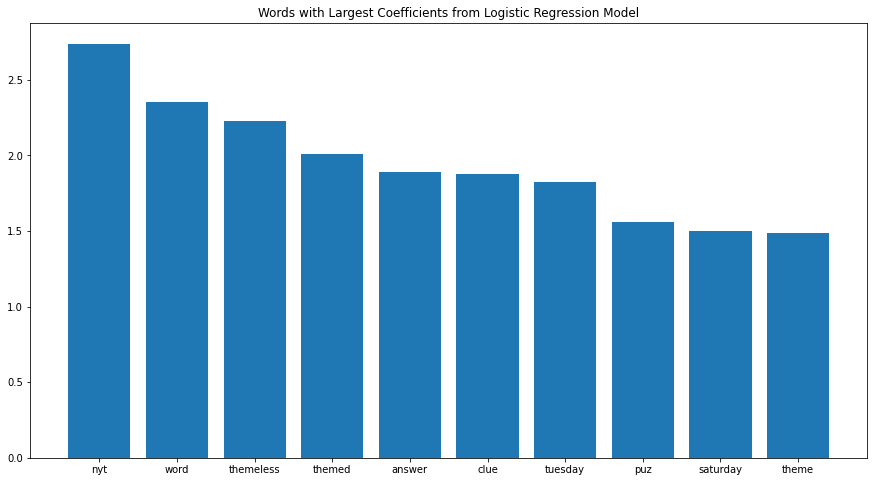

In [170]:
# Plotting the top ten coefficients by value
plt.figure(figsize=(15,8))
plot = plt.bar(x = feature_names[sorted_coef_index[:-11:-1]], height = ordered_coef_vals[:-11:-1])
plt.title('Words with Largest Coefficients from Logistic Regression Model');

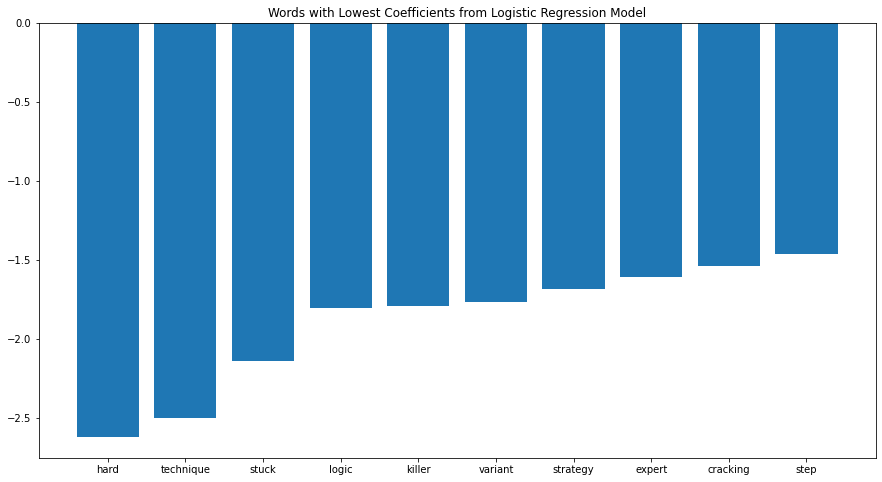

In [171]:
# Plotting the bottom ten coefficients by value
plt.figure(figsize=(15,8))
plot = plt.bar(x = feature_names[sorted_coef_index[0:10]], height = ordered_coef_vals[0:10])
plt.title('Words with Lowest Coefficients from Logistic Regression Model');

Interpretation: 

* Most of the larger coefficients look more specific to crosswords than to sudoku. New York Times crosswords are the most popular brand of crosswords, so using the 'nyt' in the crossword subreddit is expectedly common. Crosswords have themes, obviously a lot of words, and clues, whereas sudoku doesn't have those types of things.  

* Most of the words with small coefficients fit better to what sudoku is all about. Sudoku is very analytical and numbers-heavy, so words like logic make a lot of sense. 'Cracking' brings 'cracking the code' to mind. Technique and strategy are likely discussed more in sudoku; crosswords have their strategies, but a lot of the puzzle is simply having an advanced vocabulary and learning the tricks the clues use. 